# **EL KNN y una implementación para predicir la edad de una especie de molusco marino**

# **Contexto: La edad del molusco**

La edad de un molusco se puede encontrar cortando su concha y contando el número de anillos en la concha. En el conjunto de datos de moluscos, puede encontrar las mediciones de edad de una gran cantidad de moluscos junto con muchas otras mediciones físicas.
El objetivo del presente documento es desarrollar un modelo que pueda predecir la edad de un molusco basado puramente en las otras mediciones físicas. Esto permitiría a los investigadores estimar la edad del molusco sin tener que cortar su caparazón y contar los anillos.
Aplicarás un kNN para encontrar la predicción más cercana posible.


# Importación de bibliotecas

En este código, primero importa pandas, luego lo usa para leer los datos. Especifique que la ruta de acceso sea una dirección URL para que el archivo se obtenga directamente a través de Internet.
Para asegurarse de que ha importado los datos correctamente, puede realizar una comprobación rápida de la siguiente manera:


In [1]:
import pandas as pd
import numpy as np

Puede importar los datos utilizando pandas de la siguiente manera:

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"


In [3]:
molusco_df = pd.read_csv(url, header=None)
molusco_df.head()

0      1      2      3       4       5       6      7   8
0  M  0.455  0.365  0.095  0.5140  0.2245  0.1010  0.150  15
1  M  0.350  0.265  0.090  0.2255  0.0995  0.0485  0.070   7
2  F  0.530  0.420  0.135  0.6770  0.2565  0.1415  0.210   9
3  M  0.440  0.365  0.125  0.5160  0.2155  0.1140  0.155  10
4  I  0.330  0.255  0.080  0.2050  0.0895  0.0395  0.055   7

Esto debería mostrarle las primeras cinco líneas del conjunto de datos Abalone, importado en Python como un DataFrame pandas. Puede ver que todavía faltan los nombres de las columnas. Puede encontrar esos nombres en el  archivo abalone.names en el repositorio de aprendizaje automático de UCI. Puede agregarlos a su DataFrame de la siguiente manera:

In [4]:
molusco_df.columns = [
     "Sex",
     "Length",
     "Diameter",
     "Height",
     "Whole weight",
     "Shucked weight",
     "Viscera weight",
     "Shell weight",
     "Rings",
 ]

Los datos importados ahora deberían ser más comprensibles. Pero hay otra cosa que debes hacer: debes eliminar la columna Sexo. El objetivo del ejercicio actual es utilizar mediciones físicas para predecir la edad del molusco. Dado que el sexo no es una medida puramente física, debe eliminarlo del conjunto de datos. 

Puede eliminar la  columna Sexo usando .drop:

In [5]:
molusco_df = molusco_df.drop("Sex", axis=1)

In [6]:
molusco_df.head()

Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7

Con este código, eliminas la columna Sexo, ya que no tendrá ningún valor añadido en el modelado.

**Estadísticas descriptivas del conjunto de datos de abulón**

Al trabajar en el aprendizaje automático, debe tener una idea de los datos con los que está trabajando. Sin entrar en demasiada profundidad, aquí hay un vistazo a algunas estadísticas y gráficos exploratorios.
La variable objetivo de este ejercicio es Anillos, por lo que puede comenzar con eso. Un histograma le dará una visión general rápida y útil de los rangos de edad que puede esperar:


Este código utiliza la funcionalidad de trazado de pandas para generar un histograma con quince contenedores. La decisión de usar quince contenedores se basa en algunos ensayos. Al definir el número de contenedores, generalmente se intenta no tener ni demasiadas observaciones por contenedor ni muy pocas. Muy pocos contenedores pueden ocultar ciertos patrones, mientras que demasiados contenedores pueden hacer que el histograma carezca de suavidad. Puedes ver el histograma en el siguiente gráfico:

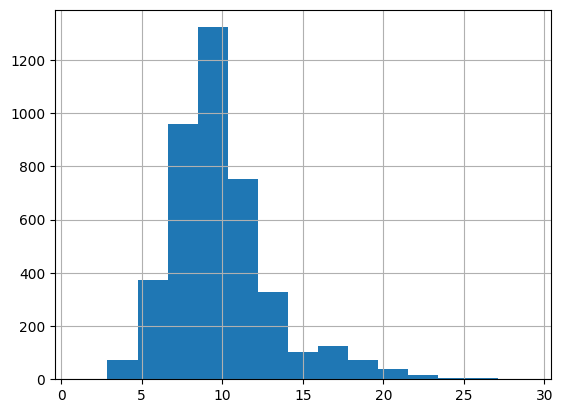

In [7]:
import matplotlib.pyplot as plt
molusco_df["Rings"].hist(bins=15)
plt.show()


El histograma muestra que la mayoría de los moluscos en el conjunto de datos tienen entre cinco y quince anillos, pero que es posible obtener hasta veinticinco anillos. 

Los moluscos más antiguos están subrepresentados en este conjunto de datos. Esto parece intuitivo, ya que las distribuciones por edades generalmente están sesgadas de esta manera debido a procesos naturales.
Una segunda exploración relevante es averiguar cuáles de las variables, si las hay, tienen una fuerte correlación con la edad. 

Una fuerte correlación entre una variable independiente y su variable objetivo sería una buena señal, ya que esto confirmaría que las mediciones físicas y la edad están relacionadas.
Puede observar la matriz de correlación completa en correlation_matrix. Las correlaciones más importantes son las que se producen con la variable objetivo Anillos. Puede obtener esas correlaciones como esta:


Ahora mire los coeficientes de correlación para anillos con las otras variables. Cuanto más cerca están de 1, más correlación hay.
Se puede concluir que hay al menos cierta correlación entre las mediciones físicas de los abulones adultos y su edad, pero tampoco es muy alta. Las correlaciones muy altas significan que puede esperar un proceso de modelado sencillo. En este caso, se intentará ver qué resultados puedes obtener usando el algoritmo kNN.


In [8]:
correlation_matrix = molusco_df.corr()
correlation_matrix["Rings"]

Length            0.556720
Diameter          0.574660
Height            0.557467
Whole weight      0.540390
Shucked weight    0.420884
Viscera weight    0.503819
Shell weight      0.627574
Rings             1.000000
Name: Rings, dtype: float64

# **Un kNN paso a paso desde cero en Python**

Se descubrirá cómo funciona el algoritmo kNN en el fondo. El algoritmo tiene dos componentes matemáticos principales que deberá comprender. Para calentar, comenzará con un recorrido en inglés simple del algoritmo kNN.

**Tutorial del algoritmo kNN**

El algoritmo kNN es un poco atípico en comparación con otros algoritmos de aprendizaje automático. Cada modelo de aprendizaje automático tiene su fórmula específica que debe estimarse. 

La especificidad del algoritmo k-Vecinos más cercanos es que esta fórmula se calcula no en el momento del ajuste, sino en el momento de la predicción. Este no es el caso para la mayoría de los otros modelos.

Cuando llega un nuevo punto de datos, el algoritmo kNN, como su nombre indica, comenzará por encontrar los vecinos más cercanos de este nuevo punto de datos. Luego toma los valores de esos vecinos y los usa como predicción para el nuevo punto de datos.

El algoritmo kNN se basa en la noción de que se pueden predecir las características de un punto de datos en función de las características de sus vecinos. 

En algunos casos, este método de predicción puede tener éxito, mientras que en otros casos puede que no. A continuación, verá la descripción matemática de "más cercano" para los puntos de datos y los métodos para combinar múltiples vecinos en una predicción.


Definir "más cercano" usando una definición matemática de distancia
Para encontrar los puntos de datos que están más cerca del punto que necesita predecir, puede usar una definición matemática de distancia llamada distancia euclidiana.

Para llegar a esta definición, primero debe comprender lo que se entiende por la diferencia de dos vectores. Aquí hay un ejemplo:


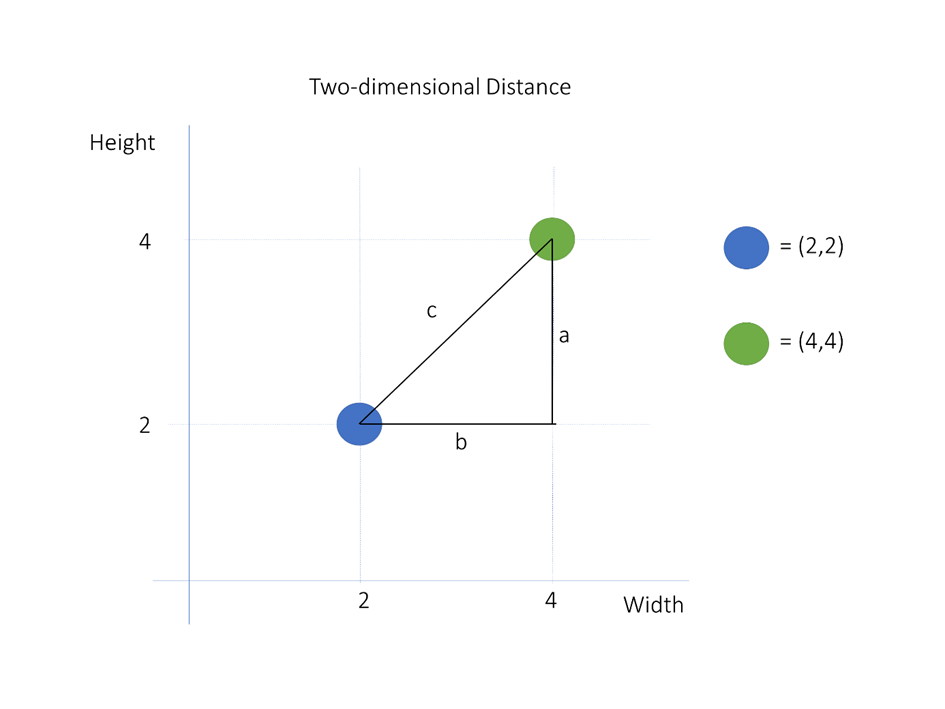

En esta imagen, verá dos puntos de datos: azul en (2,2) y verde en (4,4). Para calcular la distancia entre ellos, puede comenzar agregando dos vectores. El vector a va del punto (4,2) al punto (4,4), y el vector b va del punto (4,2) al punto (2,2). Sus cabezas están indicadas por los puntos de color. Tenga en cuenta que están en un ángulo de 90 grados.
La diferencia entre estos vectores es el vector c, que va desde la cabeza del vector  a hasta la cabeza del vector b. La longitud del vector c representa la distancia entre los dos puntos de datos.
La longitud de un vector se denomina norma. La norma es un valor positivo que indica la magnitud del vector. Puede calcular la norma de un vector utilizando la fórmula euclidiana:


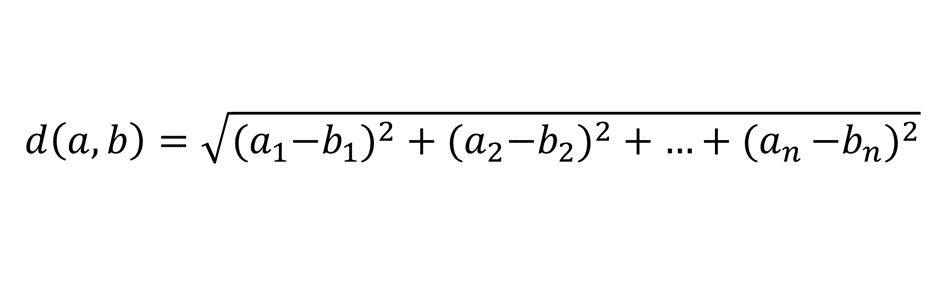

# **Encuentra los k vecinos más cercanos**

Ahora que tiene una forma de calcular la distancia desde cualquier punto a cualquier punto, puede usar esto para encontrar los vecinos más cercanos de un punto en el que desea hacer una predicción.
Necesitas encontrar un número de vecinos, y ese número está dado por k. El valor mínimo de k es 1. 

Esto significa usar solo un vecino para la predicción. El máximo es el número de puntos de datos que tiene. Esto significa usar a todos los vecinos. 

El valor de k es algo que el usuario define. Las herramientas de optimización pueden ayudarle con esto.

Ahora, para encontrar los vecinos más cercanos en NumPy, regrese al conjunto de datos de los moluscos. Como se ha visto, necesitas definir distancias en los vectores de las variables independientes, por lo que primero debes poner tu DataFrame pandas en una matriz NumPy usando el atributo .values:


In [9]:
X = molusco_df.drop("Rings", axis=1)
X = X.values
y = molusco_df["Rings"]
y = y.values

Este bloque de código genera dos objetos que ahora contienen sus datos: X e y.  X son las variables independientes e y es la variable dependiente de su modelo. 

Tenga en cuenta que utiliza una letra mayúscula para X pero una letra minúscula para y. 

Esto se hace a menudo en el código de aprendizaje automático porque la notación matemática generalmente usa una letra mayúscula para las matrices y una letra minúscula para los vectores.

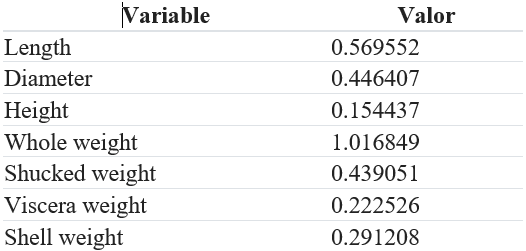

# **Aplicación kNN en Python usando scikit-learn**
Se explorará la implementación del algoritmo kNN utilizado en scikit-learn, uno de los paquetes de aprendizaje automático más completos en Python.

División de datos en conjuntos de entrenamiento y prueba para la evaluación de modelos.

En esta sección, evaluará la calidad de su modelo de kNN de moluscos. En las secciones anteriores, tenías un enfoque técnico, pero ahora vas a tener un punto de vista más pragmático y orientado a los resultados.
Existen múltiples formas de evaluar los modelos, pero la más común es la división tren-prueba. Cuando se utiliza una división tren-prueba para la evaluación del modelo, se divide el conjunto de datos en dos partes:


1.	Los datos de entrenamiento (training data) se utilizan para ajustarse al modelo. Para kNN, esto significa que los datos de entrenamiento se utilizarán como vecinos.
2.	Los datos de prueba (test data) se utilizan para evaluar el modelo. Significa que hará predicciones para el número de anillos de cada uno de los moluscos en los datos de la prueba y comparará esos resultados con el número verdadero conocido de anillos.


Puede dividir los datos en conjuntos de entrenamiento y prueba en Python   utilizando el train_test_split():

La test_size se refiere al número de observaciones que desea colocar en los datos de entrenamiento y los datos de prueba. 

Si especifica un test_size de 0,2, su test_size será el 20 por ciento de los datos originales, por lo tanto, dejará el otro 80 por ciento como datos de entrenamiento.

El random_state es un parámetro que permite obtener los mismos resultados cada vez que se ejecuta el código.  train_test_split() hace una división aleatoria en los datos, lo cual es problemático para reproducir los resultados. 

Por lo tanto, es común usar random_state. La elección del valor en random_state es arbitraria.

En el código anterior, se separan los datos en datos de entrenamiento y prueba. Esto es necesario para la evaluación objetiva del modelo. 

Ahora puede proceder a ajustar un modelo kNN en los datos de entrenamiento utilizando scikit-learn.


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=12345
)

# **Ajuste de una regresión kNN en scikit-learn al conjunto de datos de moluscos**

Para adaptarse a un modelo de scikit-learn, comience creando un modelo de la clase correcta. En este punto, también debe elegir los valores para sus hiperparámetros. Para el algoritmo kNN, debe elegir el valor de k, que se denomina n_neighbors en la implementación de scikit-learn. Así es como puedes hacer esto en Python:

In [11]:
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=3)

# **Crear un modelo no entrenado con knn_model**

Este modelo utilizará los tres vecinos más cercanos para predecir el valor de un punto de datos futuro. Para obtener los datos en el modelo, puede ajustar el modelo en el conjunto de datos de entrenamiento:

In [12]:
knn_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

Usando .fit(), deja que el modelo aprenda de los datos. En este punto, knn_model contiene todo lo que se necesita para hacer predicciones sobre nuevos puntos de datos de abulón. 

¡Ese es todo el código que necesita para ajustar una regresión kNN usando Python!

Uso de scikit-learn para inspeccionar el ajuste del modelo
Encajar un modelo, sin embargo, no es suficiente. En esta sección, verá algunas funciones que puede usar para evaluar el ajuste.
Hay muchas métricas de evaluación disponibles para la regresión, pero usará una de las más comunes, el error de raíz media cuadrada (RMSE). El RMSE de una predicción se calcula de la siguiente manera:
1.	Calcule la diferencia entre el valor real de cada punto de datos y el valor previsto.
2.	Para cada diferencia, tome el cuadrado de esta diferencia.
3.	Suma todas las diferencias al cuadrado.
4.	Tome la raíz cuadrada del valor sumado.
Para comenzar, puede evaluar el error de predicción en los datos de entrenamiento. Esto significa que utiliza los datos de entrenamiento para la predicción, por lo que sabe que el resultado debe ser relativamente bueno. Puede utilizar el código siguiente para obtener el RMSE:


In [13]:
from sklearn.metrics import mean_squared_error
from math import sqrt
train_preds = knn_model.predict(X_train)
mse = mean_squared_error(y_train, train_preds)
rmse = sqrt(mse)
rmse

1.6538366794859511

En este código, el RMSE se calcula utilizando el knn_model que ajustó en el bloque de código anterior. El RMSE se calcula en los datos de entrenamiento por ahora. Para obtener un resultado más realista, debe evaluar el rendimiento de los datos que no se incluyen en el modelo. Es por eso que mantuvo el conjunto de pruebas separado por ahora. Puede evaluar el rendimiento predictivo en el conjunto de pruebas con la misma función que antes:

In [14]:
test_preds = knn_model.predict(X_test)
mse = mean_squared_error(y_test, test_preds)
rmse = sqrt(mse)
rmse

2.375417924000521

En este bloque de código, se evalúa el error en los datos que el modelo aún no conocía. Este RMSE más realista es ligeramente más alto que antes. El RMSE mide el error medio de la edad prevista, por lo que se puede interpretar que este tiene, en promedio, un error de 1,65 años. Si una mejora de 2,37 años a 1,65 años es buena es un caso específico. Al menos te estás acercando a estimar correctamente la edad.

Hasta ahora, solo ha utilizado el algoritmo kNN scikit-learn listo para usar. Todavía no ha realizado ningún ajuste de hiperparámetros y una elección aleatoria para k. Puede observar una diferencia relativamente grande entre el RMSE en los datos de entrenamiento y el RMSE en los datos de prueba. Esto significa que el modelo sufre de sobreajuste en los datos de entrenamiento: no generaliza bien.


# **Trazar el ajuste de su modelo**

Una última cosa a tener en cuenta antes de comenzar a mejorar el modelo es el ajuste real de su modelo. Para comprender lo que el modelo ha aprendido, puede visualizar cómo se han realizado sus predicciones utilizando Matplotlib:


En este bloque de código, se utiliza Seaborn para crear un gráfico de dispersión de la primera y segunda columnas de X_test mediante la subconfiguración de las matrices X_test[:,0] y X_test[:,1]. 

Recuerda desde antes que las dos primeras columnas son Longitud y Diámetro. 

Están fuertemente correlacionados, como has visto en la tabla de correlaciones.

- Utilice c para especificar que los valores previstos (test_preds) deben utilizarse como una barra de colores. 
- El argumento s se utiliza para especificar el tamaño de los puntos en el diagrama de dispersión. 
- Cmap se utiliza  para especificar el mapa de color cubehelix_palette. 

Con el código anterior, obtendrá el siguiente gráfico:


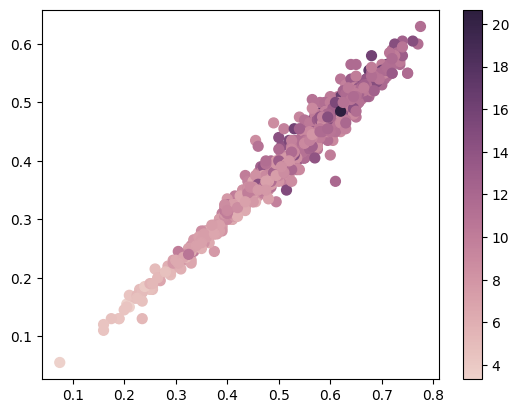

In [15]:
import seaborn as sns
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(
     X_test[:, 0], X_test[:, 1], c=test_preds, s=50, cmap=cmap
 )
f.colorbar(points)
plt.show()